In [1]:
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from numpy import mean
import seaborn as sns
import pandas as pd
import numpy as np 
import string

In [2]:
train_balanced   = pd.read_csv('D:\Datasets\Sarcasm detection//train-balanced-sarcasm.csv') 

In [3]:
train_balanced.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
train_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [5]:
train_balanced.dropna(subset = ['comment'], inplace=True)

In [6]:
train_balanced['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

## Проверка значимости колонок

In [7]:
print("score zero " , train_balanced[train_balanced['score'] == 0]['label'].describe()['mean'])
print("positive score " , train_balanced[train_balanced['score'] > 0]['label'].describe()['mean'])
print("negative score " , train_balanced[train_balanced['score'] < 0]['label'].describe()['mean'])

score zero  0.6127517586556819
positive score  0.4794612124303921
negative score  0.6689221705335919


Видно, что позитивную оценку получают примерно в равном количестве. Негативную оценку чаще получает спам, но с небольшим отрывом. 
Общей оценкой тоже можно пренебречь. Следовательно, не стоит учитывать колонки score, ups, downs при построении модели.

In [8]:
list_top15_subreddit = train_balanced['subreddit'].value_counts()[:15].index.values
list_top15_author = train_balanced['author'].value_counts()[:15].index.values

In [9]:
subreddit = pd.DataFrame()
subreddit['subreddit'] = list_top15_subreddit
subreddit[['sarcastic', 'unsarcastic', 'total']] = np.nan

In [10]:
author = pd.DataFrame()
author['author'] = list_top15_author
author[['sarcastic', 'unsarcastic', 'total']] = np.nan

In [11]:
for i in range(len(list_top15_subreddit)):
    temp = train_balanced.loc[train_balanced['subreddit'] == subreddit.subreddit.iloc[i]]
    length = len(temp)
    count_sarcastic = len(temp.loc[temp['label'] == 1])
    subreddit.sarcastic.iloc[i] = count_sarcastic
    subreddit.unsarcastic.iloc[i] = length - count_sarcastic
    subreddit.total.iloc[i] = length

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_bl

In [12]:
for i in range(len(list_top15_author)):
    temp = train_balanced.loc[train_balanced['author'] == author.author.iloc[i]]
    length = len(temp)
    count_sarcastic = len(temp.loc[temp['label'] == 1])
    author.sarcastic.iloc[i] = count_sarcastic
    author.unsarcastic.iloc[i] = length - count_sarcastic
    author.total.iloc[i] = length

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_bl

In [13]:
def graph(data, column):
    f, ax = plt.subplots(figsize=(15, 5))
    sns.barplot(x="total", y = column, data = data, label = "Total", color="salmon")
    sns.barplot(x="sarcastic", y = column, data = data, label = "Sarcastic Comments", color="cyan")
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set( ylabel="Subreddits", xlabel="Total number of comments")
    sns.despine(left=True, bottom=True)

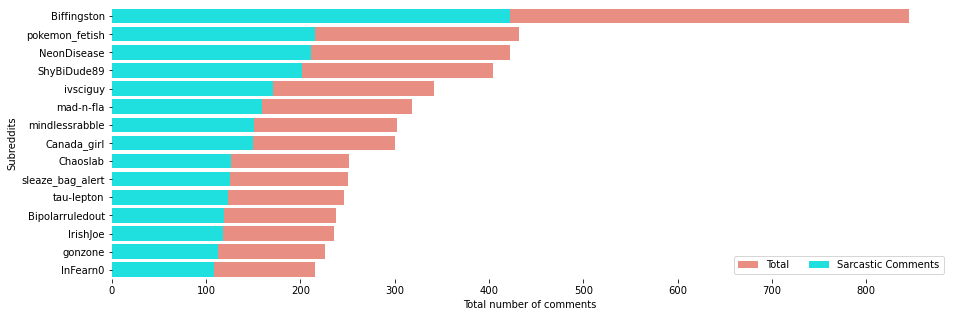

In [14]:
graph(author, author.author)

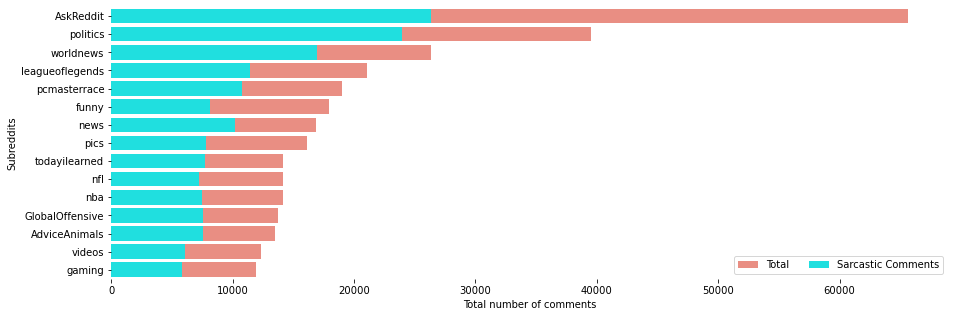

In [15]:
graph(subreddit, subreddit.subreddit)

Видим, что количество спама и обычных комментариев у разных тем и авторов примерно равно, значит исключаем эти колонки из рассмотрения.

In [16]:
train_balanced = train_balanced[['comment', 'label']]

In [17]:
def process_comment(comment):
    comment = comment.lower()
    comment = comment.replace('['+string.punctuation+']', ' ')
    words = word_tokenize(comment)
    sw = stopwords.words('english')
    words = [word for word in words if word not in sw]
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]   
    return words

In [18]:
train_balanced["comment"] = train_balanced['comment'].str.replace('[^\w\s]','')

<ipython-input-18-ba401682c935>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_balanced["comment"] = train_balanced['comment'].str.replace('[^\w\s]','')


In [19]:
%%time
train_balanced['comment'] = train_balanced['comment'].apply(lambda x: ' '.join(process_comment(x)))

Wall time: 9min 3s


In [20]:
train_balanced

,comment,label
0,nc nh,0
1,know west team play west team east team right,0
2,underdog earlier today sinc gronk announc afte...,0
3,meme isnt funni none new york nigga one,0
4,could use one tool,0
...,...,...
1010821,im sure iran n korea technolog creat pigbirdhu...,1
1010822,whatev dont vote green,1
1010823,perhap atheist conspiraci make christian look bad,1
1010824,slav got countri call kosovo,1


In [21]:
# после обработки остались пустые строки, лучше удалить
train_balanced['comment'].replace('', np.nan, inplace=True)
print(train_balanced.isnull().sum())
train_balanced.dropna(subset = ['comment'], inplace=True)

comment    7860
label         0
dtype: int64


## Кодирование данных

In [22]:
X = train_balanced.comment
y = train_balanced.label

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =1)
y_train = LabelEncoder().fit_transform(y_train)

In [24]:
TV = TfidfVectorizer() #  преобразование текстовых данных в числовую форму
TV_train = TV.fit_transform(X_train)
TV_test = TV.transform(X_test)

In [25]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [26]:
LR = LogisticRegression( penalty = 'l2', solver= 'lbfgs').fit(TV_train, y_train)
predictions_LR = LR.predict(TV_test)

scores_LR = accuracy_score(y_test, predictions_LR)
scores_LR_cross = cross_val_score(LR,  TV_test, y_test, scoring = 'accuracy', cv = cv, n_jobs = -1)

print('Accuracy до кросс-валидации = {scores_LR}, после = {scores_LR_cross}.'.format(scores_LR = round(scores_LR, 2), scores_LR_cross = round(mean(scores_LR_cross),2)))

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy до кросс-валидации = 0.67, после = 0.67.
